# Predicting Arrival Times for Denver airpot using Random Forests and Naive Bayes


#### In this assignment, you are given a series of data for 2008 for Flight arrival times for Denver airport. You will use this data to predict arrival times for planes in order to help a potential passenger figure out which flight to book so that they can avoid getting delayed.


In [125]:
#make the necessary imports here, some of the packages have already been imported, you may need to import 
#additional ones as you go along and answer the questions below

import os
import pandas as pd
import datetime as datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
pd.set_option('display.max_columns', 500) # To see all columns

#### Question 1 (1 point) Load the data in the 2008_data.csv file given with this assignment. Check that your data frame contains 299999 rows of data.

In [126]:
#your code goes here
path = 'data/'
filename = '2008_data.csv'
den = pd.read_csv(path+filename)
len(den.index)

299999

In [127]:
#look at a few rows to understand the data
den.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,N612SW,88.0,90,78.0,-6.0,-4.0,IND,BWI,515,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [128]:
# List data type for all variables
den.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance               int64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
CancellationCode      object
Diverted               int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtype: object

In [129]:
# Number of records with NaN in ArrDelay column
den[den.ArrDelay.isna()].shape[0]

8924

In [130]:
# Remove nulls in ArrDelay column
den = den[den.ArrDelay.notnull()]
den.shape

(291075, 29)

In [131]:
# Number of records with NaN in DepDelay column
den[den.DepDelay.isna()].shape[0]

0

In [132]:
# Fill null values with 0 in dataset
den = den.fillna(0)

In [133]:
den.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291075 entries, 0 to 299998
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Year               291075 non-null  int64  
 1   Month              291075 non-null  int64  
 2   DayofMonth         291075 non-null  int64  
 3   DayOfWeek          291075 non-null  int64  
 4   DepTime            291075 non-null  float64
 5   CRSDepTime         291075 non-null  int64  
 6   ArrTime            291075 non-null  float64
 7   CRSArrTime         291075 non-null  int64  
 8   UniqueCarrier      291075 non-null  object 
 9   FlightNum          291075 non-null  int64  
 10  TailNum            291075 non-null  object 
 11  ActualElapsedTime  291075 non-null  float64
 12  CRSElapsedTime     291075 non-null  int64  
 13  AirTime            291075 non-null  float64
 14  ArrDelay           291075 non-null  float64
 15  DepDelay           291075 non-null  float64
 16  Or

In [134]:
# Show summary stats of Object variables
den.select_dtypes(exclude='number').describe()

,UniqueCarrier,TailNum,Origin,Dest
count,291075,291075,291075,291075
unique,7,2103,217,216
top,WN,N693BR,PHX,PHX
freq,97375,359,14928,14925


Variable descriptions
Name	Description
1	Year	1987-2008
2	Month	1-12
3	DayofMonth	1-31
4	DayOfWeek	1 (Monday) - 7 (Sunday)
5	DepTime	actual departure time (local, hhmm)
6	CRSDepTime	scheduled departure time (local, hhmm)
7	ArrTime	actual arrival time (local, hhmm)
8	CRSArrTime	scheduled arrival time (local, hhmm)
9	UniqueCarrier	unique carrier code
10	FlightNum	flight number
11	TailNum	plane tail number
12	ActualElapsedTime	in minutes
13	CRSElapsedTime	in minutes
14	AirTime	in minutes
15	ArrDelay	arrival delay, in minutes
16	DepDelay	departure delay, in minutes
17	Origin	origin IATA airport code
18	Dest	destination IATA airport code
19	Distance	in miles
20	TaxiIn	taxi in time, in minutes
21	TaxiOut	taxi out time in minutes
22	Cancelled	was the flight cancelled?
23	CancellationCode	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24	Diverted	1 = yes, 0 = no
25	CarrierDelay	in minutes
26	WeatherDelay	in minutes
27	NASDelay	in minutes
28	SecurityDelay	in minutes
29	LateAircraftDelay	in minutes


#### Question 2 (2 points) Write code to figure out which day of the week has the most delays? You may need to first transform the data in order to do this. Also, plot a graph which shows the delay vs. day of week. 

#### (Hint 1: the sample output shown below is only for illustration purposes and may not match what you get.) 

In [135]:
#your code goes here
# Compute the average between arrival and departure delays as new column, "AvgDelay"
# This is a more nuanced approach since for example, a flight that departs late may arrive early, and vice versa
den['AvgDelay']=(den['ArrDelay']+den['DepDelay'])/2
# Output just the means of AvgDelay for each day of the week
den.groupby('DayOfWeek')['AvgDelay'].mean()

DayOfWeek
1    12.737622
2    10.918147
3     7.480614
4    15.284917
5    11.824143
6     7.983405
7    12.630441
Name: AvgDelay, dtype: float64

In [136]:
#sample output shown below

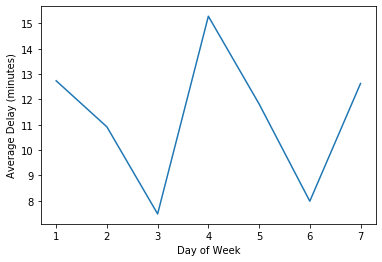

In [137]:
#your code to show plot as seen below goes here
plt.plot(den.groupby('DayOfWeek')['AvgDelay'].mean())
plt.ylabel('Average Delay (minutes)')
plt.xlabel('Day of Week')
plt.show()
# Highest average delay occurs on Thursday, followed by Monday and Sunday

#### In my case, the delay seems to be on Wednesdays and Saturdays. Not for me! Highest average delay occurs on Thursday, followed by Monday and Sunday!

#### Now that we understand the data a little bit (and you are free to do more exploration on your own, we will train two classifier to predict delays and use that information to avoid booking flights at that time.


#### Question 3 (3 points) Train a Random Forest Classifier using scikit-learn libraries to predict delay. Your outcome variable is ArrDelay. Use train-test split and report your accuracy in predicting. You are welcome to use all or a subset of the features given to you.


#### Question 4 (3 points) Train a Naive Bayes Classifier using scikit-learn libraries to predict delay. Your outcome variable is ArrDelay. Use train-test split and report your accuracy in predicting. You are welcome to use all or a subset of the features given to you.

#### Question 5 (1 point) Which classifier performed better for you? Why? 


In [138]:
#your answers to Q3, Q4 and Q5 go here
# Transform target variable, ArrDelay, to binary variable for classification of if flight is delayed or not.
den['ArrStatus'] = den['ArrDelay'].apply(lambda x: 'Delayed' if x > 0 else 'OnTime')
den

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,AvgDelay,ArrStatus
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,0,0,0.0,0.0,0.0,0.0,0.0,-3.0,OnTime
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,0,0,0.0,0.0,0.0,0.0,0.0,10.5,Delayed
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,0,0,0.0,0.0,0.0,0.0,0.0,11.0,Delayed
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,N612SW,88.0,90,78.0,-6.0,-4.0,IND,BWI,515,3.0,7.0,0,0,0,0.0,0.0,0.0,0.0,0.0,-5.0,OnTime
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,0,0,2.0,0.0,0.0,0.0,32.0,34.0,Delayed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299994,2008,1,2,3,1805.0,1755,1847.0,1845,WN,3398,N736SA,42.0,50,30.0,2.0,10.0,MCO,RSW,133,3.0,9.0,0,0,0,0.0,0.0,0.0,0.0,0.0,6.0,Delayed
299995,2008,1,2,3,1051.0,1030,1248.0,1235,WN,1112,N794SW,177.0,185,165.0,13.0,21.0,MCO,SAT,1040,2.0,10.0,0,0,0,0.0,0.0,0.0,0.0,0.0,17.0,Delayed
299996,2008,1,2,3,1558.0,1505,1758.0,1710,WN,1414,N455WN,180.0,185,164.0,48.0,53.0,MCO,SAT,1040,3.0,13.0,0,0,0,20.0,0.0,0.0,0.0,28.0,50.5,Delayed
299997,2008,1,2,3,1015.0,945,1214.0,1155,WN,187,N682SW,119.0,130,105.0,19.0,30.0,MCO,SDF,718,3.0,11.0,0,0,0,1.0,0.0,0.0,0.0,18.0,24.5,Delayed


In [139]:
# Keep ArrStatus as label, and check frequency
ArrStatus = den['ArrStatus']
ArrStatus.value_counts()

OnTime     154739
Delayed    136336
Name: ArrStatus, dtype: int64

In [140]:
# Let's set a naive baseline for accuracy comparison later. We use the most frequent class as baseline model.
# If model outputs "OnTime" always, our accuracy is:
print(154739/(154739+136336))

0.5316121274585588


In [141]:
# Import LabelEncoder
#from sklearn import preprocessing
#creating labelEncoder
#le = preprocessing.LabelEncoder()
#Converting string labels into numbers.
#label=le.fit_transform(ArrStatus)
#print ("ArrStatus:",label)
#label


# Drop variables not used for modeling
den_clean = den.drop(['ArrDelay', 'Year', 'Month', 'AirTime', 'TailNum', 'FlightNum', 'Cancelled', 
                      'CancellationCode', 'DepTime', 'ArrTime', 'AvgDelay', 'ActualElapsedTime','CRSDepTime',
                      'CRSArrTime','CRSElapsedTime', 'ArrStatus'], axis=1) 
# Year and Month removed as they are constants
# ArrStatus is our label and since this is the feature set, removed
# ArrDelay has been converted to our categorical label variable above, removed
# AvgDelay is the variable I created, and since it includes ArrDelay, removed
# TailNum, FlightNum - irrelevant categorical data used to identify the flight
# Cancelled, CancellationCode - a cancelled flight is irrelevant to our model
# Time variables would introduce multicollinearity, so retained only Distance variable and kept it simple
den_clean

,DayofMonth,DayOfWeek,UniqueCarrier,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,3,4,WN,8.0,IAD,TPA,810,4.0,8.0,0,0.0,0.0,0.0,0.0,0.0
1,3,4,WN,19.0,IAD,TPA,810,5.0,10.0,0,0.0,0.0,0.0,0.0,0.0
2,3,4,WN,8.0,IND,BWI,515,3.0,17.0,0,0.0,0.0,0.0,0.0,0.0
3,3,4,WN,-4.0,IND,BWI,515,3.0,7.0,0,0.0,0.0,0.0,0.0,0.0
4,3,4,WN,34.0,IND,BWI,515,3.0,10.0,0,2.0,0.0,0.0,0.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299994,2,3,WN,10.0,MCO,RSW,133,3.0,9.0,0,0.0,0.0,0.0,0.0,0.0
299995,2,3,WN,21.0,MCO,SAT,1040,2.0,10.0,0,0.0,0.0,0.0,0.0,0.0
299996,2,3,WN,53.0,MCO,SAT,1040,3.0,13.0,0,20.0,0.0,0.0,0.0,28.0
299997,2,3,WN,30.0,MCO,SDF,718,3.0,11.0,0,1.0,0.0,0.0,0.0,18.0


In [142]:
# One-hot Encoding for categorical variables
den_clean = pd.get_dummies(den_clean, columns = ['DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'], 
                           drop_first=True)
# Dropping first column from each categorical variable, so that all zeroes signify these as baseline:
# ['DayofMonth_1', 'DayOfWeek_1', 'UniqueCarrier_OH', 'Origin_ABE', 'Dest_ABE'])
den_clean

,DepDelay,Distance,TaxiIn,TaxiOut,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DayofMonth_2,DayofMonth_3,DayofMonth_4,DayofMonth_5,DayofMonth_6,DayofMonth_7,DayofMonth_8,DayofMonth_9,DayofMonth_10,DayofMonth_11,DayofMonth_12,DayofMonth_13,DayofMonth_14,DayofMonth_15,DayofMonth_16,DayofMonth_17,DayofMonth_18,DayofMonth_19,DayofMonth_20,DayofMonth_21,DayofMonth_22,DayofMonth_23,DayofMonth_24,DayofMonth_25,DayofMonth_26,DayofMonth_27,DayofMonth_28,DayofMonth_29,DayofMonth_30,DayofMonth_31,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV,Origin_ABQ,Origin_ACV,Origin_ACY,Origin_AEX,Origin_ALB,Origin_AMA,Origin_ANC,Origin_ASE,Origin_ATL,Origin_ATW,Origin_AUS,Origin_AVL,Origin_AVP,Origin_AZO,Origin_BDL,Origin_BFL,Origin_BGR,Origin_BHM,Origin_BIL,Origin_BIS,Origin_BLI,Origin_BMI,Origin_BNA,Origin_BOI,Origin_BOS,Origin_BPT,Origin_BRO,Origin_BTM,Origin_BTR,Origin_BTV,Origin_BUF,Origin_BUR,Origin_BWI,Origin_BZN,Origin_CAE,Origin_CAK,Origin_CDC,Origin_CEC,Origin_CHA,Origin_CHS,Origin_CIC,Origin_CID,Origin_CLD,Origin_CLE,Origin_CLL,Origin_CLT,Origin_CMH,Origin_COD,Origin_COS,Origin_CPR,Origin_CRP,Origin_CRW,Origin_CVG,Origin_CWA,Origin_DAB,Origin_DAL,Origin_DAY,Origin_DCA,Origin_DEN,Origin_DFW,Origin_DRO,Origin_DSM,Origin_DTW,Origin_EGE,Origin_EKO,Origin_ELP,Origin_EUG,Origin_EWR,Origin_FAR,Origin_FAT,Origin_FCA,Origin_FLG,Origin_FLL,Origin_FSD,Origin_FWA,Origin_GEG,Origin_GJT,Origin_GPT,Origin_GRB,Origin_GRK,Origin_GRR,Origin_GSO,Origin_GSP,Origin_GTF,Origin_GUC,Origin_HDN,Origin_HLN,Origin_HNL,Origin_HOU,Origin_HPN,Origin_HRL,Origin_HSV,Origin_IAD,Origin_IAH,Origin_ICT,Origin_IDA,Origin_ILM,Origin_IND,Origin_IPL,Origin_ISP,Origin_ITO,Origin_IYK,Origin_JAC,Origin_JAN,Origin_JAX,Origin_JFK,Origin_KOA,Origin_LAN,Origin_LAS,Origin_LAX,Origin_LBB,Origin_LCH,Origin_LEX,Origin_LFT,Origin_LGA,Origin_LGB,Origin_LIH,Origin_LIT,Origin_LNK,Origin_LRD,Origin_LWS,Origin_MAF,Origin_MBS,Origin_MCI,Origin_MCO,Origin_MDT,Origin_MDW,Origin_MEM,Origin_MFE,Origin_MFR,Origin_MGM,Origin_MHT,Origin_MIA,Origin_MKE,Origin_MLB,Origin_MLI,Origin_MLU,Origin_MOB,Origin_MOD,Origin_MRY,Origin_MSN,Origin_MSO,Origin_MSP,Origin_MSY,Origin_MTJ,Origin_MYR,Origin_OAK,Origin_OGG,Origin_OKC,Origin_OMA,Origin_ONT,Origin_ORD,Origin_ORF,Origin_OXR,Origin_PBI,Origin_PDX,Origin_PHL,Origin_PHX,Origin_PIA,Origin_PIH,Origin_PIT,Origin_PMD,Origin_PNS,Origin_PSC,Origin_PSP,Origin_PVD,Origin_PWM,Origin_RAP,Origin_RDD,Origin_RDM,Origin_RDU,Origin_RFD,Origin_RIC,Origin_RNO,Origin_ROA,Origin_ROC,Origin_RSW,Origin_SAN,Origin_SAT,Origin_SAV,Origin_SBA,Origin_SBN,Origin_SBP,Origin_SDF,Origin_SEA,Origin_SFO,Origin_SGF,Origin_SGU,Origin_SHV,Origin_SJC,Origin_SJU,Origin_SLC,Origin_SLE,Origin_SMF,Origin_SMX,Origin_SNA,Origin_SPI,Origin_SRQ,Origin_STL,Origin_STT,Origin_STX,Origin_SUN,Origin_SYR,Origin_TEX,Origin_TLH,Origin_TPA,Origin_TRI,Origin_TUL,Origin_TUS,Origin_TVC,Origin_TWF,Origin_TYS,Origin_VPS,Origin_XNA,Origin_YKM,Origin_YUM,Dest_ABQ,Dest_ACV,Dest_AEX,Dest_ALB,Dest_AMA,Dest_ANC,Dest_ASE,Dest_ATL,Dest_ATW,Dest_AUS,Dest_AVL,Dest_AVP,Dest_AZO,Dest_BDL,Dest_BFL,Dest_BGR,Dest_BHM,Dest_BIL,Dest_BIS,Dest_BLI,Dest_BMI,Dest_BNA,Dest_BOI,Dest_BOS,Dest_BPT,Dest_BRO,Dest_BTM,Dest_BTR,Dest_BTV,Dest_BUF,Dest_BUR,Dest_BWI,Dest_BZN,Dest_CAE,Dest_CAK,Dest_CDC,Dest_CEC,Dest_CHA,Dest_CHS,Dest_CIC,Dest_CID,Dest_CLD,Dest_CLE,Dest_CLL,Dest_CLT,Dest_CMH,Dest_COD,Dest_COS,Dest_CPR,Dest_CRP,Dest_CRW,Dest_CVG,Dest_CWA,Dest_DAB,Dest_DAL,Dest_DAY,Dest_DCA,Dest_DEN,Dest_DFW,Dest_DRO,Dest_DSM,Dest_DTW,Dest_EGE,Dest_EKO,Dest_ELP,Dest_EUG,Dest_EWR,Dest_FAR,Dest_FAT,Dest_FCA,Dest_FLG,Dest_FLL,Dest_FSD,Dest_FWA,Dest_GEG,Dest_GJT,Dest_GPT,Dest_GRB,Dest_GRK,Dest_GRR,Dest_GSO,Dest_GSP,Dest_GTF,Dest_GUC,Dest_HDN,Dest_HLN,Dest_HNL,Dest_HOU,Dest_HPN,Dest_HRL,Dest_HSV,Dest_IAD,Dest_IAH,Dest_ICT,Dest_IDA,Dest_ILM,Dest_IND,Dest_IPL,Dest_ISP,Dest_ITO,Dest_IYK,Dest_JAC,Dest_JAN,D

# Q3 RANDOM FOREST CLASSIFIER

In [143]:
# 70-30 train/test split
X_train, X_test, y_train, y_test = train_test_split(den_clean, ArrStatus, test_size=0.30, random_state=42)

In [144]:
# Build Random Forest classifier using default settings
rf=RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [145]:
# Calculate mean accuracy on training set
rf.score(X_train,y_train)

0.9941644744591465

In [146]:
# Output predictions using X_test
y_pred = rf.predict(X_test)
y_pred

array(['OnTime', 'OnTime', 'Delayed', ..., 'Delayed', 'OnTime', 'OnTime'],
      dtype=object)

In [147]:
# Calculate mean accuracy on test set
rf.score(X_test,y_test)

0.8565555466486493

In [148]:
# Calculate accuracy (to confirm), precision and recall using metrics package
print(f"Accuracy:\n{round(metrics.accuracy_score(y_test,y_pred),4)}")
print(f"Precision:\n{metrics.precision_score(y_test,y_pred,average=None)}")
print(f"Recall:\n{metrics.recall_score(y_test,y_pred,average=None)}")

Accuracy:
0.8566
Precision:
[0.86204778 0.85211122]
Recall:
[0.82507903 0.88416889]


In [149]:
# Classification report 
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

     Delayed       0.86      0.83      0.84     40807
      OnTime       0.85      0.88      0.87     46516

    accuracy                           0.86     87323
   macro avg       0.86      0.85      0.86     87323
weighted avg       0.86      0.86      0.86     87323



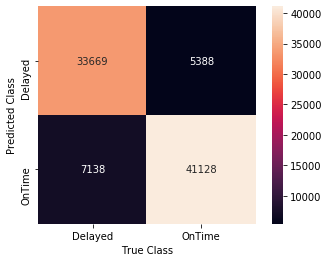

In [150]:
# Heatmapped Confusion Matrix
mat=confusion_matrix(y_test,y_pred)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=True, 
            xticklabels=['Delayed','OnTime'],
            yticklabels=['Delayed','OnTime'])
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [151]:
# Tuning
# Iterate through hyperparameters using 3-fold cross-validated grid search 
# We set n_jobs = -1 to use all processors
parameters = {'n_estimators':[10,100], 'max_depth': [30,40,50]}
rf_classifier = RandomForestClassifier(n_jobs=-1, random_state=42)
classifier = GridSearchCV(rf_classifier,parameters, cv=3)
classifier.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

In [152]:
# Which parameters were found to be best?
classifier.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [153]:
# Train Random Forest model using best hyperparameters from cross-validated grid search
bestclassifier = RandomForestClassifier(**classifier.best_estimator_.get_params())
bestclassifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [154]:
# Output predictions using X_test
y_pred = bestclassifier.predict(X_test)
y_pred

array(['OnTime', 'OnTime', 'Delayed', ..., 'Delayed', 'OnTime', 'OnTime'],
      dtype=object)

In [155]:
# Calculate mean accuracy on training set
bestclassifier.score(X_train,y_train)

0.9661402096666536

In [156]:
# Calculate mean accuracy on test set
bestclassifier.score(X_test,y_test)

0.8681790593543511

In [157]:
# Calculate accuracy (to confirm), precision and recall on test set using metrics package
print(f"Accuracy:\n{round(metrics.accuracy_score(y_test,y_pred),4)}")
print(f"Precision:\n{metrics.precision_score(y_test,y_pred,average=None)}")
print(f"Recall:\n{metrics.recall_score(y_test,y_pred,average=None)}")

Accuracy:
0.8682
Precision:
[0.92154944 0.83290537]
Recall:
[0.78471831 0.94139651]


In [158]:
# Classification report 
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

     Delayed       0.92      0.78      0.85     40807
      OnTime       0.83      0.94      0.88     46516

    accuracy                           0.87     87323
   macro avg       0.88      0.86      0.87     87323
weighted avg       0.87      0.87      0.87     87323



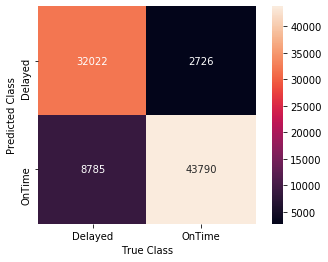

In [159]:
# Heatmapped Confusion Matrix
mat=confusion_matrix(y_test,y_pred)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=True, 
            xticklabels=['Delayed','OnTime'],
            yticklabels=['Delayed','OnTime'])
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

# Q4 NAIVE BAYES CLASSIFER

In [160]:
# Initiate Gaussian Naive Bayes Classifier
gnb = GaussianNB()
# Fit model using train and predict on test set
y_pred = gnb.fit(X_train, y_train).predict(X_test)
# Calculate mean accuracy on training set
gnb.score(X_train, y_train)

0.7665544387294357

In [161]:
# Mislabeled points on test set, just to confirm next calculation
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 87323 points : 20347


In [162]:
# Calculate mean accuracy on test set (1-20347/87323)
gnb.score(X_test, y_test)

0.766991514263138

In [163]:
# Calculate accuracy (to confirm), precision and recall using metrics package
print(f"Accuracy:\n{round(metrics.accuracy_score(y_test,y_pred),4)}")
print(f"Precision:\n{metrics.precision_score(y_test,y_pred,average=None)}")
print(f"Recall:\n{metrics.recall_score(y_test,y_pred,average=None)}")

Accuracy:
0.767
Precision:
[0.86509636 0.72063808]
Recall:
[0.59401573 0.91873764]


In [164]:
# Classification report 
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

     Delayed       0.87      0.59      0.70     40807
      OnTime       0.72      0.92      0.81     46516

    accuracy                           0.77     87323
   macro avg       0.79      0.76      0.76     87323
weighted avg       0.79      0.77      0.76     87323



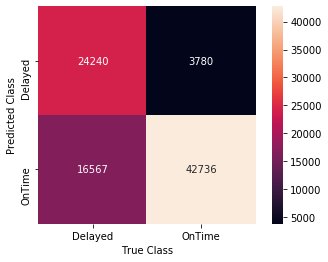

In [165]:
# Heatmapped Confusion Matrix
mat=confusion_matrix(y_test,y_pred)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=True, 
            xticklabels=['Delayed','OnTime'],
            yticklabels=['Delayed','OnTime'])
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

# Q5 Which classifier performed better and why?

The Random Forest Classifier performs better at ~87% accuracy on test set, while also having higher precision and recall than the Naive Bayes Classifier(see classification report and confusion matrixes above). I was also able to tune hyperparameters via Grid Search to increase accuracy and lessen overfitting. The Naive Bayes Classifer is roughly ~10% less accurate. This is understandable since Naive Bayes classification is simpler and relies only on priors. Gaussian Naive Bayes also assumes independence among features, as well as normality, which is a perfect scenario and not exactly true here. However, it still gives good and quick classification estimations, no tuning required. Importantly, overfitting seems to not be an issue as it is with the Random Forest Classifier.

Both classifiers do quite a bit better than the 53% accuracy calculated earlier of a model that outputs majority class all of the time.